In [2]:
import pandas as pd
import numpy as np

# 1. Load Data
print("Loading dataset...")
df = pd.read_csv('merged_cleaned.csv')

# 2. Handle Timestamp
# Convert to datetime and set as the index (required for resampling)
df['Full_Timestamp'] = pd.to_datetime(df['Full_Timestamp'])
df = df.sort_values('Full_Timestamp')
df = df.set_index('Full_Timestamp')

# 3. Define the Aggregation Rules
# Tell Pandas exactly how to combine the twelve 5-minute rows into a single 1-hour row
agg_dict = {
    # Targets (Average them)
    'Soiling loss': 'mean',
    'Power Curve_Cleaned': 'mean',
    'Power Curve_Uncleaned': 'mean',
    
    # Standard Weather (Average them)
    'Temperature (°C)': 'mean',
    'Relative humidity (%)': 'mean',
    'Dew point (°C)': 'mean',
    'Atm pressure. (hPa)': 'mean',
    'Solar rad (W/m²)': 'mean',
    'Wind speed (m/s)': 'mean',
    
    # Particulate Matter (Average them)
    'PM1.0 (µg/m³)': 'mean',
    'PM2.5 (µg/m³)': 'mean',
    'PM10 (µg/m³)': 'mean',
    
    # Extremes and Cumulative (Take the Maximum)
    'Wind gust (m/s)': 'max',
    'Max rain rate (mm/h)': 'max',
    'Daily rain (mm)': 'max',
    'Total Rainfall (mm)': 'max'
}

# (Optional) If you want to keep the Voltage and Current columns, add them to the dictionary as 'mean'
# agg_dict['Cleaned_Voltage'] = 'mean'
# agg_dict['Cleaned_Current'] = 'mean'
# agg_dict['Uncleaned_Voltage'] = 'mean'
# agg_dict['Uncleaned_Current'] = 'mean'

# 4. Perform the Resampling
# '1H' stands for 1 Hour. 
print("Resampling to 1-hour intervals...")
df_hourly = df.resample('1h').agg(agg_dict)

# Wind Direction Exception:
# Averaging angles directly is mathematically dangerous (e.g., the average of 359° and 1° is 180°, which is backward).
# If you need wind direction, you can use the median or the last recorded value of that hour.
if 'Wind dir (deg)' in df.columns:
    df_hourly['Wind dir (deg)'] = df['Wind dir (deg)'].resample('1h').median()

# 5. Clean up missing data
# If there was a gap in your sensor data, resampling will create a row of NaNs. We drop those.
original_rows = len(df)
df_hourly = df_hourly.dropna()
new_rows = len(df_hourly)

print(f"Original 5-min rows: {original_rows}")
print(f"New Hourly rows: {new_rows}")

# 6. Save the new dataset
df_hourly.to_csv('merged_cleaned_hourly.csv')
print("Saved to 'merged_cleaned_hourly.csv'")

Loading dataset...
Resampling to 1-hour intervals...
Original 5-min rows: 40541
New Hourly rows: 3598
Saved to 'merged_cleaned_hourly.csv'


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Linear Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, BayesianRidge
# Tree-based and Ensemble Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, 
    AdaBoostRegressor, HistGradientBoostingRegressor
)
# Other Standard Models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor

# Advanced Boosting Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 1. Load Data
df = pd.read_csv('merged_cleaned_hourly.csv')

# 2. Define Features (X) and Targets (Y)
features = [
    'Wind dir (deg)', 'Solar rad (W/m²)', 'Wind speed (m/s)', 'Wind gust (m/s)',
    'Temperature (°C)', 'Relative humidity (%)', 'Dew point (°C)', 'Atm pressure. (hPa)',
    'Max rain rate (mm/h)', 'Daily rain (mm)', 'Total Rainfall (mm)',
    'PM1.0 (µg/m³)', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)'
]

targets = ['Soiling loss', 'Power Curve_Cleaned', 'Power Curve_Uncleaned']

# Drop rows with missing values
df = df.dropna(subset=features + targets)

X = df[features]
Y = df[targets]

# 3. Train/Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 4. Normalization / Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Define All Models
# Single-output models are wrapped in MultiOutputRegressor
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=42),
    "Lasso Regression": Lasso(random_state=42),
    "ElasticNet": ElasticNet(random_state=42),
    "Bayesian Ridge": MultiOutputRegressor(BayesianRidge()),
    "Huber Regressor (Robust)": MultiOutputRegressor(HuberRegressor()),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "AdaBoost": MultiOutputRegressor(AdaBoostRegressor(random_state=42)),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
    "Hist-Gradient Boosting": MultiOutputRegressor(HistGradientBoostingRegressor(random_state=42)),
    "XGBoost": MultiOutputRegressor(XGBRegressor(random_state=42, objective='reg:squarederror')),
    "LightGBM": MultiOutputRegressor(LGBMRegressor(random_state=42, verbose=-1)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(random_state=42, verbose=0)),
    "Support Vector Regressor": MultiOutputRegressor(SVR()),
    "Simple ANN (MLP)": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# 6. Training and Evaluation Loop
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # Fit model
    model.fit(X_train_scaled, Y_train)
    
    # Predict
    Y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics for each target separately
    for i, target_name in enumerate(targets):
        
        y_true_target = Y_test.iloc[:, i]
        y_pred_target = Y_pred[:, i]
        
        mse = mean_squared_error(y_true_target, y_pred_target)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true_target, y_pred_target)
        r2 = r2_score(y_true_target, y_pred_target)
        
        results.append({
            "Target": target_name,
            "Model": name,
            "MSE": round(mse, 4),
            "RMSE": round(rmse, 4),
            "MAE": round(mae, 4),
            "R2 Score": round(r2, 4)
        })

# 7. Display Results
results_df = pd.DataFrame(results)

print("\n" + "="*50)
print(" MODEL PERFORMANCE PER TARGET ")
print("="*50)

for target_name in targets:
    print(f"\n--- Target: {target_name} ---")
    
    target_df = results_df[results_df["Target"] == target_name].drop(columns=["Target"])
    target_df = target_df.sort_values(by="R2 Score", ascending=False)
    
    print(target_df.to_string(index=False))

Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training ElasticNet...
Training Bayesian Ridge...
Training Huber Regressor (Robust)...
Training K-Nearest Neighbors...
Training Decision Tree...
Training Random Forest...
Training Extra Trees...
Training AdaBoost...
Training Gradient Boosting...
Training Hist-Gradient Boosting...
Training XGBoost...
Training LightGBM...


/opt/anaconda3/envs/Solar/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/Solar/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/Solar/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Training CatBoost...
Training Support Vector Regressor...
Training Simple ANN (MLP)...

 MODEL PERFORMANCE PER TARGET 

--- Target: Soiling loss ---
                   Model    MSE   RMSE    MAE  R2 Score
                 XGBoost 0.0002 0.0157 0.0082    0.7566
  Hist-Gradient Boosting 0.0003 0.0158 0.0080    0.7527
                LightGBM 0.0003 0.0159 0.0081    0.7495
                CatBoost 0.0003 0.0163 0.0083    0.7383
       Gradient Boosting 0.0003 0.0183 0.0098    0.6685
             Extra Trees 0.0004 0.0205 0.0116    0.5870
           Random Forest 0.0004 0.0206 0.0111    0.5826
     K-Nearest Neighbors 0.0006 0.0241 0.0143    0.4280
           Decision Tree 0.0008 0.0280 0.0143    0.2251
                AdaBoost 0.0008 0.0282 0.0226    0.2130
       Linear Regression 0.0008 0.0285 0.0182    0.2002
        Ridge Regression 0.0008 0.0285 0.0182    0.2002
          Bayesian Ridge 0.0008 0.0285 0.0182    0.1990
Huber Regressor (Robust) 0.0009 0.0300 0.0165    0.1098
           

Calculating feature importance for Soiling loss using CatBoost...
Calculating feature importance for Power Curve_Cleaned using CatBoost...
Calculating feature importance for Power Curve_Uncleaned using CatBoost...


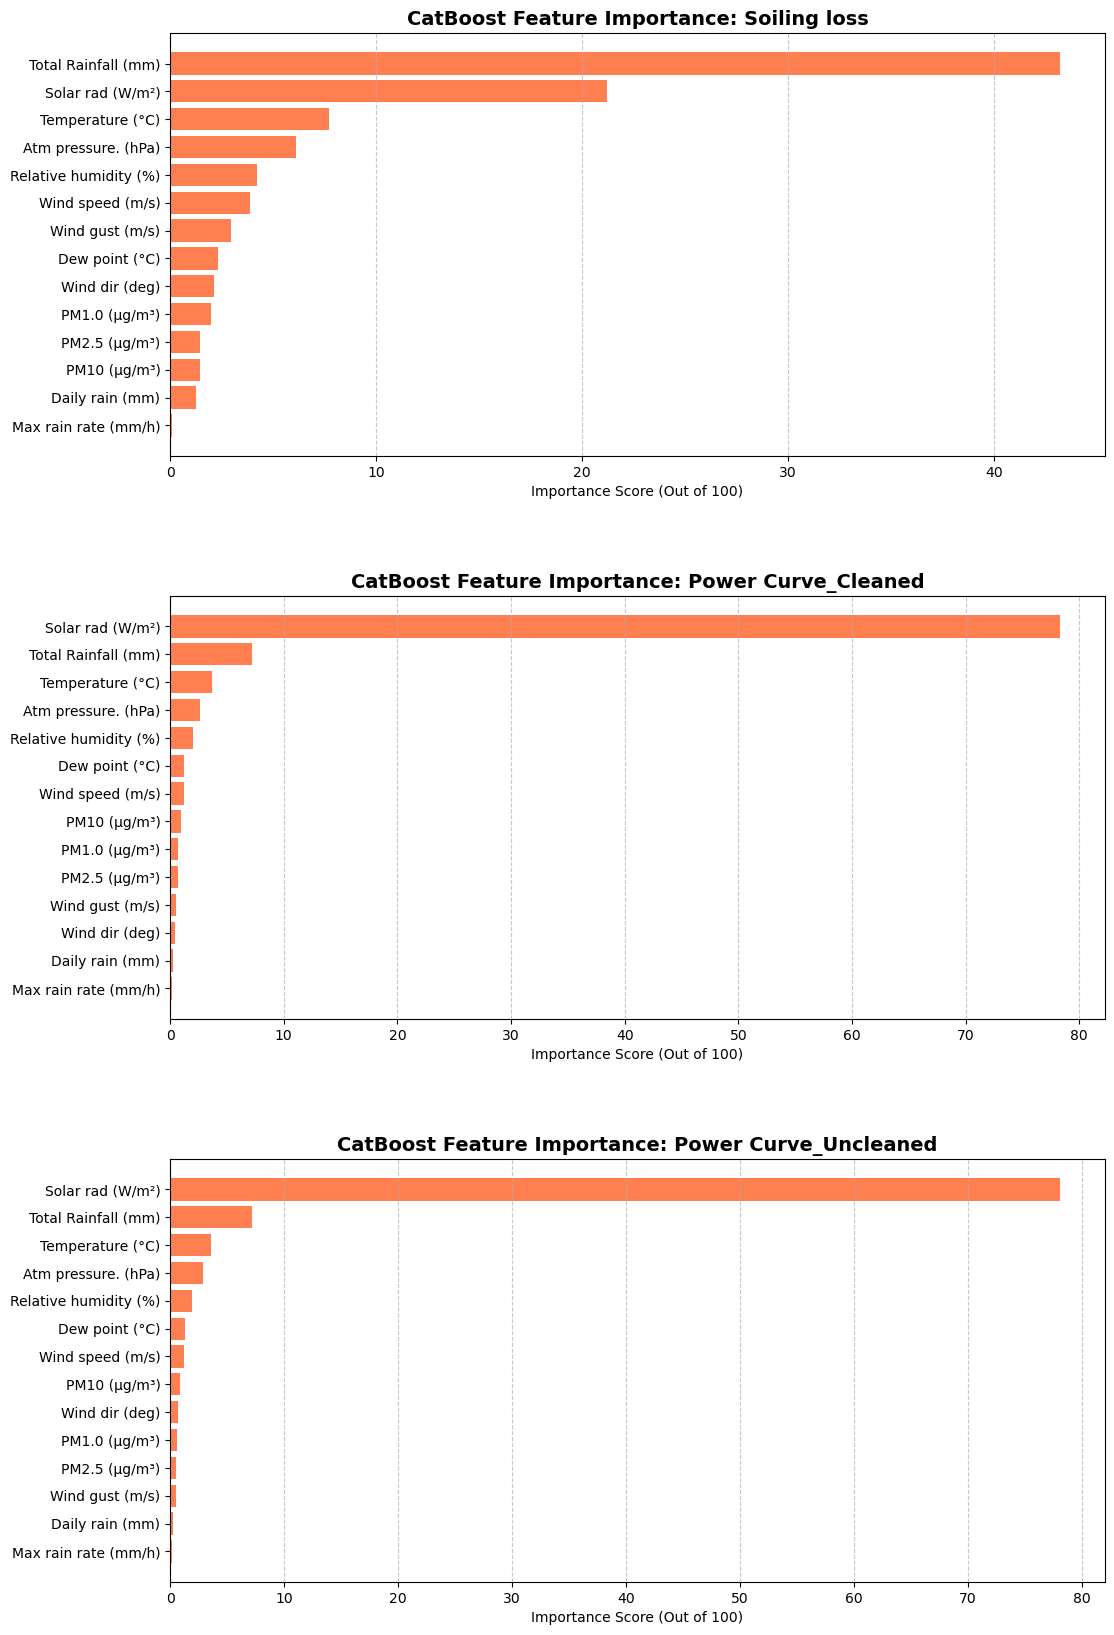

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

# 1. Load Data
# Replace 'merged_cleaned_hourly.csv' with your actual file path
df = pd.read_csv('merged_cleaned_hourly.csv')

# 2. Define Features and Targets
features = [
    'Wind dir (deg)', 'Solar rad (W/m²)', 'Wind speed (m/s)', 'Wind gust (m/s)',
    'Temperature (°C)', 'Relative humidity (%)', 'Dew point (°C)', 'Atm pressure. (hPa)',
    'Max rain rate (mm/h)', 'Daily rain (mm)', 'Total Rainfall (mm)',
    'PM1.0 (µg/m³)', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)'
]

targets = ['Soiling loss', 'Power Curve_Cleaned', 'Power Curve_Uncleaned']

df = df.dropna(subset=features + targets)

X = df[features]
Y = df[targets]

# 3. Setup the Plot
# We will create 3 subplots (one for each target)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
fig.tight_layout(pad=8.0)

# 4. Train and Plot Loop
for i, target_name in enumerate(targets):
    print(f"Calculating feature importance for {target_name} using CatBoost...")
    
    # Isolate the specific target
    y_target = Y[target_name]
    
    # Initialize and fit the CatBoost Regressor
    # verbose=0 keeps the console clean by suppressing the training iteration text
    model = CatBoostRegressor(random_state=42, verbose=0)
    model.fit(X, y_target)
    
    # Extract importances and map them to the feature names
    # CatBoost provides importances as a percentage (0 to 100) by default
    importances = model.get_feature_importance()
    
    # Create a DataFrame for easy sorting
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })
    
    # Sort from most important to least important
    importance_df = importance_df.sort_values(by='Importance', ascending=True)
    
    # Plotting
    axes[i].barh(importance_df['Feature'], importance_df['Importance'], color='coral')
    axes[i].set_title(f'CatBoost Feature Importance: {target_name}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Importance Score (Out of 100)')
    axes[i].grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

Success! PyTorch will use your Mac's GPU (MPS).
Creating sequences with 36 time steps...

Training PyTorch LSTM Model with Scheduler and Early Stopping...
Epoch [001/150] | Train Loss: 0.7844 | Val Loss: 1.3712 | Patience: 0/15
Epoch [005/150] | Train Loss: 0.3184 | Val Loss: 1.1235 | Patience: 1/15
Epoch [010/150] | Train Loss: 0.2733 | Val Loss: 1.1377 | Patience: 6/15 | LR reduced to 0.0005
Epoch [015/150] | Train Loss: 0.2743 | Val Loss: 1.1473 | Patience: 11/15
Epoch [016/150] | Train Loss: 0.2530 | Val Loss: 1.1383 | Patience: 12/15 | LR reduced to 0.00025

Early stopping triggered at Epoch 19! No improvement in validation loss for 15 consecutive epochs.

Loading best model weights for final evaluation...

 BEST PYTORCH LSTM PERFORMANCE PER TARGET 
               Target      MSE    RMSE     MAE  R2 Score
         Soiling loss   0.0023  0.0474  0.0271   -0.3365
  Power Curve_Cleaned 388.3249 19.7060 16.1352    0.6945
Power Curve_Uncleaned 329.0311 18.1392 14.6662    0.7122


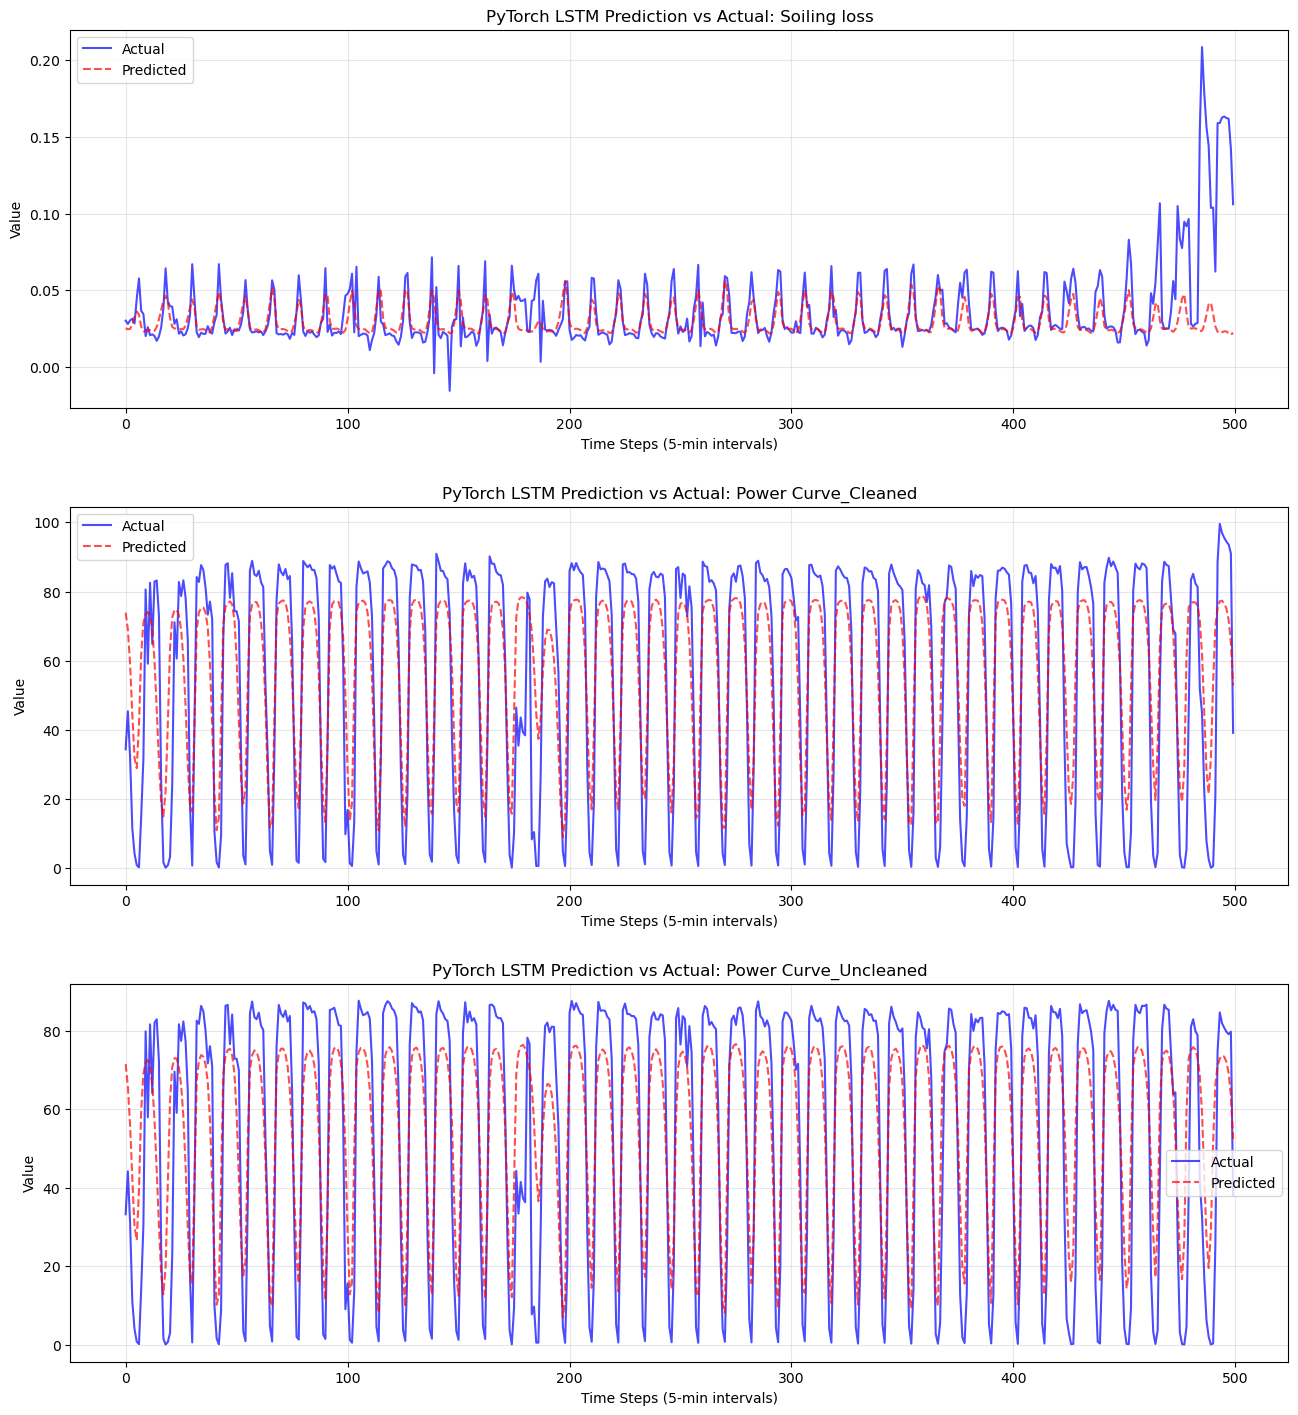

In [5]:
##############
#    LSTM
##############

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 0. MAC GPU (MPS) SETUP
# ==========================================
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success! PyTorch will use your Mac's GPU (MPS).")
else:
    device = torch.device("cpu")
    print("Warning: MPS not available. PyTorch will use the CPU.")

# ==========================================
# 1. LOAD DATA & HANDLE TIMESTAMP
# ==========================================
df = pd.read_csv('merged_cleaned_hourly.csv')

df['Full_Timestamp'] = pd.to_datetime(df['Full_Timestamp'])
df = df.sort_values('Full_Timestamp')
df = df.set_index('Full_Timestamp') 

# ==========================================
# 2. DEFINE FEATURES AND TARGETS
# ==========================================
features = [
    'Wind dir (deg)', 'Solar rad (W/m²)', 'Wind speed (m/s)', 'Wind gust (m/s)',
    'Temperature (°C)', 'Relative humidity (%)', 'Dew point (°C)', 'Atm pressure. (hPa)',
    'Max rain rate (mm/h)', 'Daily rain (mm)', 'Total Rainfall (mm)',
    'PM1.0 (µg/m³)', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)'
]
targets = ['Soiling loss', 'Power Curve_Cleaned', 'Power Curve_Uncleaned']

df = df.dropna(subset=features + targets)

# ==========================================
# 3. SCALING
# ==========================================
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(df[features])
Y_scaled = scaler_Y.fit_transform(df[targets])

# ==========================================
# 4. CREATE SEQUENCES (SLIDING WINDOW)
# ==========================================
def create_sequences(X, Y, time_steps):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        Ys.append(Y[i + time_steps])
    return np.array(Xs), np.array(Ys)

TIME_STEPS = 36 
print(f"Creating sequences with {TIME_STEPS} time steps...")
X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, TIME_STEPS)

# ==========================================
# 5. CHRONOLOGICAL SPLIT & PYTORCH DATALOADERS
# ==========================================
split_index = int(len(X_seq) * 0.80)

X_train_t = torch.tensor(X_seq[:split_index], dtype=torch.float32)
Y_train_t = torch.tensor(Y_seq[:split_index], dtype=torch.float32)
X_test_t = torch.tensor(X_seq[split_index:], dtype=torch.float32)
Y_test_t = torch.tensor(Y_seq[split_index:], dtype=torch.float32)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=batch_size, shuffle=False)

# ==========================================
# 6. BUILD THE PYTORCH LSTM MODEL
# ==========================================
class MultiOutputLSTM(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=32, output_size=3):
        super(MultiOutputLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        
        out, _ = self.lstm2(out)
        out = self.dropout2(out)
        
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

input_features = X_train_t.shape[2]
model = MultiOutputLSTM(input_size=input_features, output_size=len(targets)).to(device)

criterion = nn.MSELoss()

# Added weight_decay (L2 Regularization) to penalize overly large weights and prevent overfitting
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize the Learning Rate Scheduler
# If val_loss doesn't improve for 5 epochs, cut the learning rate in half
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# ==========================================
# 7. TRAIN THE MODEL (SCHEDULER & EARLY STOPPING)
# ==========================================
epochs = 150 # Increased max epochs since early stopping will catch it
best_val_loss = float('inf')
best_model_path = 'best_lstm_weights.pth'

# Early Stopping parameters
patience_counter = 0
early_stopping_patience = 15 # Stop if no improvement after 15 epochs

print("\nTraining PyTorch LSTM Model with Scheduler and Early Stopping...")

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train() 
    train_loss = 0
    
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        
        optimizer.zero_grad() 
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)
        
        loss.backward()
        
        # Gradient Clipping: Prevents gradients from exploding, ensuring stable learning
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)

    # --- VALIDATION PHASE ---
    model.eval() 
    val_loss = 0
    with torch.no_grad():
        for batch_X_val, batch_Y_val in val_loader:
            batch_X_val, batch_Y_val = batch_X_val.to(device), batch_Y_val.to(device)
            val_preds = model(batch_X_val)
            v_loss = criterion(val_preds, batch_Y_val)
            val_loss += v_loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    # Step the scheduler using the validation loss
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Checkpoint & Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0 # Reset patience if we hit a new record
    else:
        patience_counter += 1

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0 or new_lr != current_lr:
        lr_msg = f" | LR reduced to {new_lr}" if new_lr != current_lr else ""
        print(f"Epoch [{epoch+1:03d}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Patience: {patience_counter}/{early_stopping_patience}{lr_msg}")

    # Trigger Early Stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered at Epoch {epoch+1}! No improvement in validation loss for {early_stopping_patience} consecutive epochs.")
        break

# ==========================================
# 8. PREDICT AND EVALUATE (USING BEST MODEL)
# ==========================================
print("\nLoading best model weights for final evaluation...")
model.load_state_dict(torch.load(best_model_path))
model.eval() 

with torch.no_grad():
    X_test_gpu = X_test_t.to(device)
    Y_pred_scaled = model(X_test_gpu).cpu().numpy()

Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_test_actual = scaler_Y.inverse_transform(Y_test_t.numpy())

results = []

for i, target_name in enumerate(targets):
    y_true_target = Y_test_actual[:, i]
    y_pred_target = Y_pred[:, i]
    
    mse = mean_squared_error(y_true_target, y_pred_target)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_target, y_pred_target)
    r2 = r2_score(y_true_target, y_pred_target)
    
    results.append({
        "Target": target_name,
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "R2 Score": round(r2, 4)
    })

results_df = pd.DataFrame(results)
print("\n" + "="*50)
print(" BEST PYTORCH LSTM PERFORMANCE PER TARGET ")
print("="*50)
print(results_df.to_string(index=False))

# ==========================================
# 9. VISUALIZATION
# ==========================================
PLOT_SAMPLES = 500 

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 15))
fig.tight_layout(pad=5.0)

for i, target_name in enumerate(targets):
    axes[i].plot(Y_test_actual[:PLOT_SAMPLES, i], label='Actual', color='blue', alpha=0.7)
    axes[i].plot(Y_pred[:PLOT_SAMPLES, i], label='Predicted', color='red', alpha=0.7, linestyle='--')
    axes[i].set_title(f'PyTorch LSTM Prediction vs Actual: {target_name}')
    axes[i].set_xlabel('Time Steps (5-min intervals)')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.show()

Success! PyTorch will use your Mac's GPU (MPS).

Training Transformer Model with Scheduler and Early Stopping...
Epoch [001/150] | Train Loss: 0.7219 | Val Loss: 1.4539 | Patience: 0/15
Epoch [005/150] | Train Loss: 0.3581 | Val Loss: 1.0797 | Patience: 0/15
Epoch [010/150] | Train Loss: 0.2887 | Val Loss: 1.1031 | Patience: 5/15
Epoch [011/150] | Train Loss: 0.2788 | Val Loss: 1.1720 | Patience: 6/15 | LR reduced to 5e-05
Epoch [015/150] | Train Loss: 0.2338 | Val Loss: 1.1133 | Patience: 10/15
Epoch [017/150] | Train Loss: 0.2303 | Val Loss: 1.1451 | Patience: 12/15 | LR reduced to 2.5e-05
Epoch [020/150] | Train Loss: 0.2106 | Val Loss: 1.1493 | Patience: 15/15

Early stopping triggered at Epoch 20! No improvement in validation loss for 15 consecutive epochs.

Loading best model weights for final evaluation...

 BEST TRANSFORMER PERFORMANCE PER TARGET 
               Target      MSE    RMSE     MAE  R2 Score
         Soiling loss   0.0024  0.0486  0.0281   -0.4052
  Power Curve_Clea

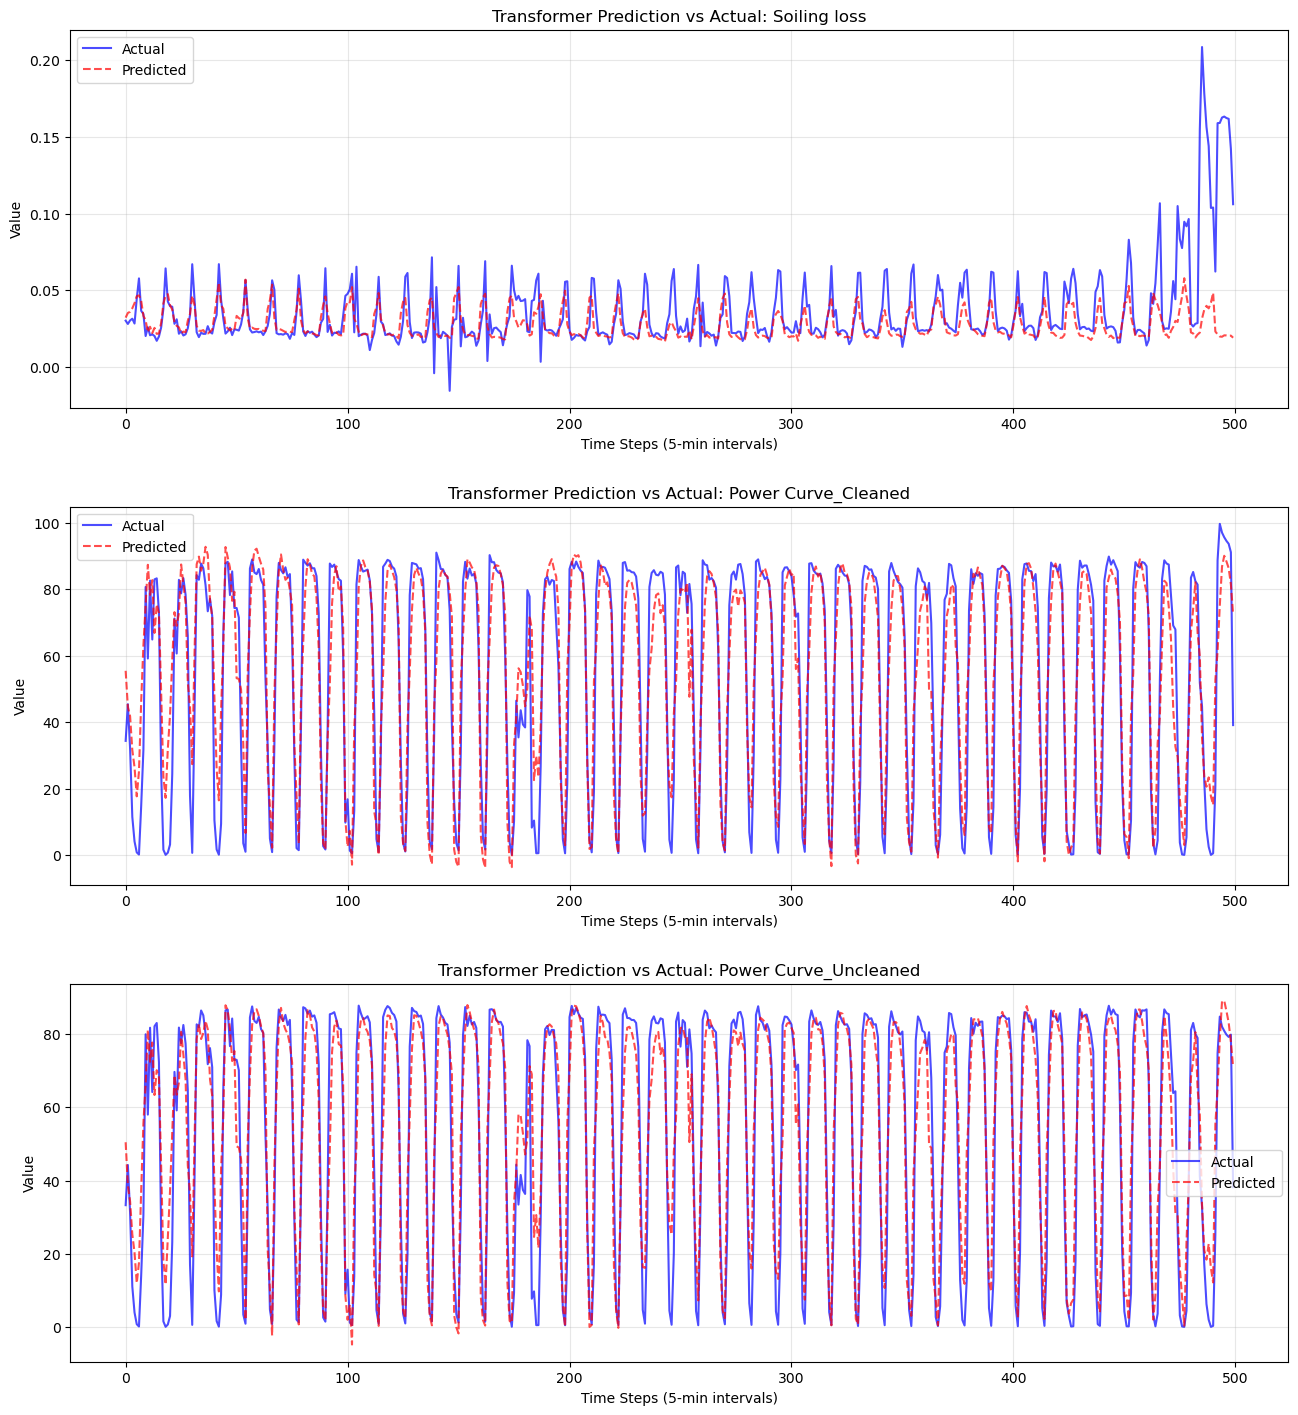

In [6]:
########
#   Transformer
########

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 0. MAC GPU (MPS) SETUP
# ==========================================
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Success! PyTorch will use your Mac's GPU (MPS).")
else:
    device = torch.device("cpu")
    print("Warning: MPS not available. Using CPU.")

# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
df = pd.read_csv('merged_cleaned_hourly.csv')
df['Full_Timestamp'] = pd.to_datetime(df['Full_Timestamp'])
df = df.set_index('Full_Timestamp').sort_index()

features = [
    'Wind dir (deg)', 'Solar rad (W/m²)', 'Wind speed (m/s)', 'Wind gust (m/s)',
    'Temperature (°C)', 'Relative humidity (%)', 'Dew point (°C)', 'Atm pressure. (hPa)',
    'Max rain rate (mm/h)', 'Daily rain (mm)', 'Total Rainfall (mm)',
    'PM1.0 (µg/m³)', 'PM2.5 (µg/m³)', 'PM10 (µg/m³)'
]
targets = ['Soiling loss', 'Power Curve_Cleaned', 'Power Curve_Uncleaned']

df = df.dropna(subset=features + targets)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(df[features])
Y_scaled = scaler_Y.fit_transform(df[targets])

# Sliding window (3 hours of 5-min data)
TIME_STEPS = 36 

def create_sequences(X, Y, time_steps):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        Ys.append(Y[i + time_steps])
    return np.array(Xs), np.array(Ys)

X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, TIME_STEPS)

# Chronological split
split_index = int(len(X_seq) * 0.80)
X_train_t = torch.tensor(X_seq[:split_index], dtype=torch.float32)
Y_train_t = torch.tensor(Y_seq[:split_index], dtype=torch.float32)
X_test_t = torch.tensor(X_seq[split_index:], dtype=torch.float32)
Y_test_t = torch.tensor(Y_seq[split_index:], dtype=torch.float32)

# Create Training and Validation DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, Y_train_t), batch_size=64, shuffle=False)
val_loader = DataLoader(TensorDataset(X_test_t, Y_test_t), batch_size=64, shuffle=False)

# ==========================================
# 2. DEFINE POSITIONAL ENCODING
# ==========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# ==========================================
# 3. BUILD THE TRANSFORMER MODEL
# ==========================================
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=3, output_size=3, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        
        self.input_projection = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, output_size)

    def forward(self, src):
        x = self.input_projection(src)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :] 
        out = self.output_layer(x)
        return out

input_features = len(features)
model = TimeSeriesTransformer(
    input_size=input_features, d_model=64, nhead=4, num_layers=3, output_size=len(targets)
).to(device)

criterion = nn.MSELoss()

# Added weight_decay (L2 Regularization) to prevent overfitting
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5) 

# Initialize the Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# ==========================================
# 4. TRAIN AND VALIDATE THE MODEL
# ==========================================
epochs = 150 # Increased max epochs since early stopping will catch it
best_val_loss = float('inf')
best_model_path = 'best_transformer_weights.pth'

# Early Stopping parameters
patience_counter = 0
early_stopping_patience = 15

print("\nTraining Transformer Model with Scheduler and Early Stopping...")

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train() 
    train_loss = 0
    
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)
        
        loss.backward()
        # Gradient clipping is highly recommended for Transformers
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(train_loader)

    # --- VALIDATION PHASE (Calculated every epoch) ---
    model.eval() 
    val_loss = 0
    
    with torch.no_grad():
        for batch_X_val, batch_Y_val in val_loader:
            batch_X_val, batch_Y_val = batch_X_val.to(device), batch_Y_val.to(device)
            
            val_preds = model(batch_X_val)
            v_loss = criterion(val_preds, batch_Y_val)
            val_loss += v_loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    # Step the scheduler using the validation loss
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Checkpoint & Early Stopping Logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0 # Reset patience
    else:
        patience_counter += 1
        
    # Print progress every 5 epochs OR if the learning rate just dropped
    if (epoch + 1) % 5 == 0 or epoch == 0 or new_lr != current_lr:
        lr_msg = f" | LR reduced to {new_lr}" if new_lr != current_lr else ""
        print(f"Epoch [{epoch+1:03d}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Patience: {patience_counter}/{early_stopping_patience}{lr_msg}")

    # Trigger Early Stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered at Epoch {epoch+1}! No improvement in validation loss for {early_stopping_patience} consecutive epochs.")
        break

# ==========================================
# 5. PREDICT AND EVALUATE (USING BEST MODEL)
# ==========================================
print("\nLoading best model weights for final evaluation...")
model.load_state_dict(torch.load(best_model_path))
model.eval()

with torch.no_grad():
    X_test_gpu = X_test_t.to(device)
    Y_pred_scaled = model(X_test_gpu).cpu().numpy()

Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_test_actual = scaler_Y.inverse_transform(Y_test_t.numpy())

results = []
for i, target_name in enumerate(targets):
    y_true_target = Y_test_actual[:, i]
    y_pred_target = Y_pred[:, i]
    
    mse = mean_squared_error(y_true_target, y_pred_target)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_target, y_pred_target)
    r2 = r2_score(y_true_target, y_pred_target)
    
    results.append({
        "Target": target_name,
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "R2 Score": round(r2, 4)
    })

results_df = pd.DataFrame(results)
print("\n" + "="*50)
print(" BEST TRANSFORMER PERFORMANCE PER TARGET ")
print("="*50)
print(results_df.to_string(index=False))

# ==========================================
# 6. VISUALIZATION
# ==========================================
PLOT_SAMPLES = 500 

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 15))
fig.tight_layout(pad=5.0)

for i, target_name in enumerate(targets):
    axes[i].plot(Y_test_actual[:PLOT_SAMPLES, i], label='Actual', color='blue', alpha=0.7)
    axes[i].plot(Y_pred[:PLOT_SAMPLES, i], label='Predicted', color='red', alpha=0.7, linestyle='--')
    axes[i].set_title(f'Transformer Prediction vs Actual: {target_name}')
    axes[i].set_xlabel('Time Steps (5-min intervals)')
    axes[i].set_ylabel('Value')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.show()